In [ ]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer as LabelBinarize
import _pickle as pickle

from sklearn import model_selection
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.preprocessing import normalize 

from keras.layers.convolutional import Conv2D, ZeroPadding2D

from keras.layers.core import Reshape, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras import metrics
import matplotlib.pyplot as plt
import tensorflow as tf

import tarfile
import pickle
import random
import keras
import sys
import requests
import os
import gc

In [ ]:
IN = (30,30)
model_conv = Sequential()
model_conv.add(Reshape((30,30,1), input_shape=IN))
model_conv.add(keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 30, 30, 1)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 1)         0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


**Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = 'drive/My Drive/AssignFour/RML2016.10b.dat'

In [ ]:
openedFile = open(file_path,'rb')
data = pickle.load(openedFile, encoding='latin1')
print(data[('QPSK', 2)].shape)
print(data[('PAM4', 8)].shape)
keys_list = list(data.keys())
temp_data = []
label_data = []

for i in range(len(keys_list)):
    curr_item = data[keys_list[i]] 
    temp_data.append(curr_item)
    for j in range(curr_item.shape[0]):
        label_data.append(keys_list[i])
        

data = np.array(temp_data).reshape(1200000,2,128)

labels = np.array(label_data)

print(data.shape)

print(labels.shape)


(6000, 2, 128)
(6000, 2, 128)
(1200000, 2, 128)
(1200000, 2)


# **Fully Connected Layer**

In [ ]:
def build_fc_model(in_shape):
  model = Sequential()
  model.add(Dense(128, activation ='relu', input_shape = in_shape))
  model.add(Flatten())
  model.add(Dense(10, activation ='softmax'))
  return model

In [ ]:
def fully_connected(train_x, train_l, test_x, test_l, filename):
  model = build_fc_model(train_x[0].shape)
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
  model.summary()
  model.fit(train_x, train_l, epochs = 100, validation_split = 0.05, batch_size = 2048, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])
  filename += "fully_connected.h5"
  filename_with_path = 'drive/My Drive/AssignFour/' + filename
  model.save(filename_with_path)
  results = model.evaluate(test_x, test_l, batch_size=128)
  print("test loss, test acc:", results)

# CNN

In [ ]:
in_shape = (1,306)
model = build_cnn_model(train_x[0].shape)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()
model.fit(train_x, train_l, epochs = 80, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])
      

results = model.evaluate(test_x, test_l, batch_size=128)
print("test loss, test acc:", results)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

In [ ]:
def cnn(train_x, train_l, test_x, test_l, filename):
  model = build_cnn_model(train_x[0].shape)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
  model.summary()
  model.fit(train_x, train_l, epochs = 80, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])
        
  filename += "cnn.h5"
  filename_with_path = 'drive/My Drive/AssignFour/' + filename
  model.save(filename_with_path)
  results = model.evaluate(test_x, test_l, batch_size=128)
  print("test loss, test acc:", results)

# **Apply On Feature Space**

**Raw time series as given (two channels)**

In [ ]:
raw_feature = data.copy()

X_train, X_test, y_train, y_test = model_selection.train_test_split(raw_feature, labels, test_size= 0.3, random_state = 42)

lb = LabelBinarize()
lb.fit_transform(labels[:,0])
y_train = lb.transform(y_train[:,0])
y_test = lb.transform(y_test[:,0])

del(raw_feature)
gc.collect()
fully_connected(X_train, y_train, X_test, y_test, "raw_")
cnn(X_train, y_train, X_test, y_test, "raw_")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2, 128)            16512     
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 19,082
Trainable params: 19,082
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 2s 4ms/step - loss: 2.2045 - accuracy: 0.1757 - val_loss: 2.0017 - val_accuracy: 0.2459
Epoch 2/100
390/390 [==============================] - 1s 4ms/step - loss: 1.9652 - accuracy: 0.2577 - val_loss: 1.8610 - val_accuracy: 0.2856
Epoch 3/100
390/390 [==============================] - 1s 4ms/step - loss: 1.8391 - accuracy: 

**First derivative in time (two channels)**

In [ ]:
data_for_derivative = data.copy()
der_data = []
for d in data_for_derivative:
  d[0] = np.gradient(d[0])
  d[1] = np.gradient(d[1])
  d = normalize(d, axis=1)
  der_data.append(d)

der_data = np.array(der_data)
#normalize(der_data,axis=1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(der_data, labels, test_size= 0.3, random_state = 42)


lb = LabelBinarize()
lb.fit_transform(labels[:,0])
y_train = lb.transform(y_train[:,0])
y_test = lb.transform(y_test[:,0])

del(der_data)
del(data_for_derivative)
gc.collect()
fully_connected(X_train, y_train, X_test, y_test, "derivative_")
cnn(X_train, y_train, X_test, y_test, "derivative_")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2, 128)            16512     
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 19,082
Trainable params: 19,082
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 2s 4ms/step - loss: 2.2084 - accuracy: 0.1678 - val_loss: 1.9855 - val_accuracy: 0.2611
Epoch 2/100
390/390 [==============================] - 1s 4ms/step - loss: 1.9635 - accuracy: 0.2703 - val_loss: 1.9174 - val_accuracy: 0.2844
Epoch 3/100
390/390 [==============================] - 1s 4ms/step - loss: 1.9060 - accuracy: 



**Integral in time (two channels)**

In [ ]:
data_for_integral = data.copy()
int_data = []
for d in data_for_integral:
  d[0] = np.cumsum(d[0])
  d[1] = np.cumsum(d[1])
  int_data.append(d)

int_data = np.array(int_data)

X_train, X_test, y_train, y_test = model_selection.train_test_split(int_data, labels, test_size= 0.3, random_state = 42)


lb = LabelBinarize()
lb.fit_transform(labels[:,0])
y_train = lb.transform(y_train[:,0])
y_test = lb.transform(y_test[:,0])

del(int_data)
del(data_for_integral)
gc.collect()
fully_connected(X_train, y_train, X_test, y_test, "integral_")
cnn(X_train, y_train, X_test, y_test, "integral_")


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2, 128)            16512     
_________________________________________________________________
flatten_6 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2570      
Total params: 19,082
Trainable params: 19,082
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 2s 4ms/step - loss: 2.0701 - accuracy: 0.1951 - val_loss: 1.9263 - val_accuracy: 0.2503
Epoch 2/100
390/390 [==============================] - 1s 3ms/step - loss: 1.9089 - accuracy: 0.2618 - val_loss: 1.8644 - val_accuracy: 0.2760
Epoch 3/100
390/390 [==============================] - 1s 3ms/step - loss: 1.8555 - accuracy: 

**combinations of 1,2 and 3. (More channels)**

In [ ]:
data_for_comb = data.copy()
comb_data = []
for d in data_for_comb:
  d1 = np.cumsum(d[0])
  d2 = np.cumsum(d[1])
  d1.reshape(1,-1)
  d2.reshape(1,-1)
  d4 = np.gradient(d[0])
  d5 = np.gradient(d[1])
  d4.reshape(1,-1)
  d5.reshape(1,-1)
  d3 = np.array([d[0], d[1], d1 , d2, d4, d5])
  comb_data.append(d3)

comb_data = np.array(comb_data)


X_train, X_test, y_train, y_test = model_selection.train_test_split(comb_data, labels, test_size= 0.3, random_state = 42)

lb = LabelBinarize()
lb.fit_transform(labels[:,0])
y_train = lb.transform(y_train[:,0])
y_test = lb.transform(y_test[:,0])

del(comb_data)
del(data_for_comb)
gc.collect()
fully_connected(X_train, y_train, X_test, y_test, "comb_")
cnn(X_train, y_train, X_test, y_test, "comb_")


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 6, 128)            16512     
_________________________________________________________________
flatten_8 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                7690      
Total params: 24,202
Trainable params: 24,202
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 2s 6ms/step - loss: 2.0729 - accuracy: 0.1996 - val_loss: 1.9249 - val_accuracy: 0.2588
Epoch 2/100
390/390 [==============================] - 2s 5ms/step - loss: 1.9064 - accuracy: 0.2642 - val_loss: 1.8589 - val_accuracy: 0.2797
Epoch 3/100
390/390 [==============================] - 2s 5ms/step - loss: 1.8438 - accuracy:

# Evaluation Part

**Graph SNR Vs Accuracy**

In [ ]:
def plot_the_graph(y_pred, y_real , sn_test , feat , m_name):
  snr_axis = []
  acc_axis = []
  snrs_sorted = np.sort(np.unique(sn_test))
  plt.title('Plot of Accuracy against SNR for ' + feat + ' at ' +  m_name)
  plt.xlabel('SNR-IN-DB')
  plt.ylabel('Accuracy %')
  for snr in snrs_sorted:
    snr_axis.append(snr)
    idx = np.where(sn_test == snr)
    acc_axis.append(accuracy_score(np.argmax(y_real[idx], axis = 1), np.argmax(y_pred[idx], axis = 1)))
  plt.plot(snr_axis, np.array(acc_axis) * 100, 'bo--')
  plt.grid(True)

**Confusion Matrix**

In [ ]:
def get_confusion_matrix(y_preds, y_reals , classes_name, feat , m_name):
  y_reals = np.argmax(y_reals, axis = 1)
  y_preds =  np.argmax(y_preds, axis = 1)
  mapping = plt.cm.Greens
  cm = confusion_matrix(y_reals, y_preds)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, axing = plt.subplots()
  im_sq = axing.imshow(cm, interpolation='nearest', cmap=mapping)
  axing.figure.colorbar(im_sq, ax=axing)
  axing.set(xticks=np.arange(cm.shape[1]), xticklabels=classes_name, yticks=np.arange(cm.shape[0]), yticklabels=classes_name,
         ylabel = 'Real labels', xlabel = 'Predicted labels', title = 'Confusion Matrix for ' + feat + ' at ' +  m_name)
  plt.setp(axing.get_xticklabels(), rotation= 90, ha="right", rotation_mode="anchor")

# *Evaluation on raw time*

In [ ]:
raw_feature = data.copy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(raw_feature, labels, test_size= 0.3, random_state = 42)
snr_test = y_test[:,1].astype(int)
lb = LabelBinarize()
lb.fit_transform(labels[:,0])
y_test = lb.transform(y_test[:,0])
ev_fcl_model = keras.models.load_model('drive/My Drive/AssignFour/raw_fully_connected.h5')
ev_cnn_model = keras.models.load_model('drive/My Drive/AssignFour/raw_cnn.h5')
y_pred_fcl = ev_fcl_model.predict(X_test)
y_pred_cnn = ev_cnn_model.predict(X_test)
del(raw_feature)
gc.collect()

653

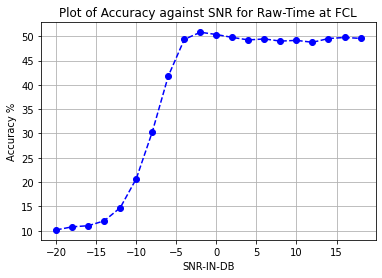

In [ ]:
plot_the_graph(y_pred_fcl, y_test, snr_test,'Raw-Time', 'FCL')

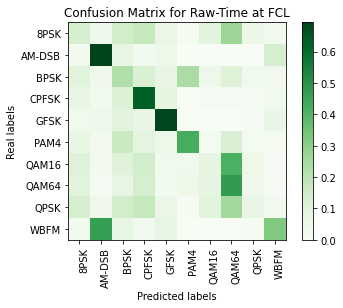

In [ ]:
classes_string = ['8PSK','AM-DSB','BPSK','CPFSK','GFSK','PAM4','QAM16','QAM64','QPSK','WBFM']
get_confusion_matrix(y_pred_fcl, y_test, classes_string, 'Raw-Time', 'FCL')

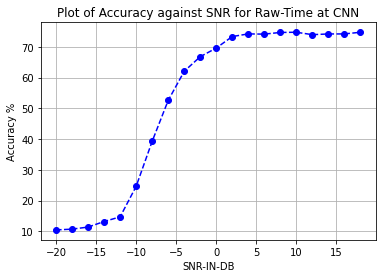

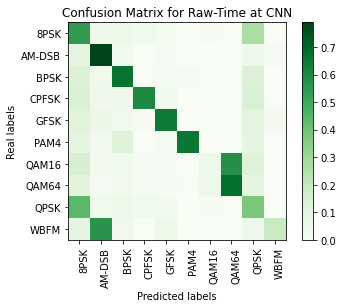

In [ ]:
plot_the_graph(y_pred_cnn, y_test, snr_test, 'Raw-Time', 'CNN')
classes_string = ['8PSK','AM-DSB','BPSK','CPFSK','GFSK','PAM4','QAM16','QAM64','QPSK','WBFM']
get_confusion_matrix(y_pred_cnn, y_test, classes_string , 'Raw-Time', 'CNN')

# Evaluate For Derivative

In [ ]:
data_for_derivative = data.copy()
der_data = []
for d in data_for_derivative:
  d[0] = np.gradient(d[0])
  d[1] = np.gradient(d[1])
  d = normalize(d, axis=1)
  der_data.append(d)
der_data = np.array(der_data)
X_train, X_test, y_train, y_test = model_selection.train_test_split(der_data, labels, test_size= 0.3, random_state = 42)
snr_test = y_test[:,1].astype(int)
lb = LabelBinarize()
lb.fit_transform(labels[:,0])
y_test = lb.transform(y_test[:,0])
ev_fcl_model = keras.models.load_model('drive/My Drive/AssignFour/derivative_fully_connected.h5')
ev_cnn_model = keras.models.load_model('drive/My Drive/AssignFour/derivative_cnn.h5')
y_pred_fcl = ev_fcl_model.predict(X_test)
y_pred_cnn = ev_cnn_model.predict(X_test)
del(der_data)
del(data_for_derivative)
gc.collect()

25976

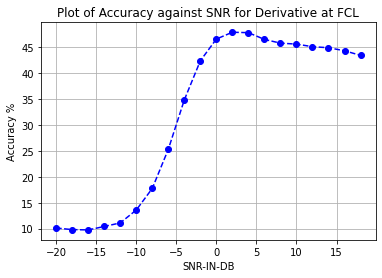

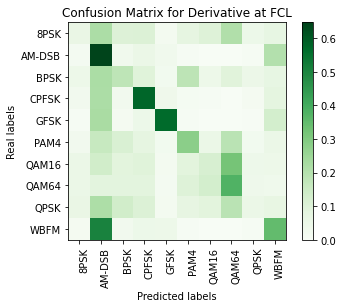

In [ ]:
classes_string = ['8PSK','AM-DSB','BPSK','CPFSK','GFSK','PAM4','QAM16','QAM64','QPSK','WBFM']
plot_the_graph(y_pred_fcl, y_test, snr_test,'Derivative', 'FCL')
get_confusion_matrix(y_pred_fcl, y_test, classes_string, 'Derivative', 'FCL')

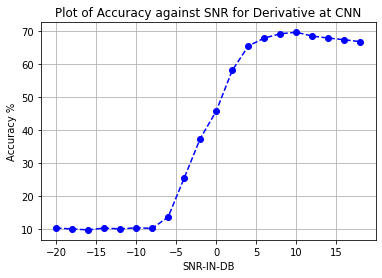

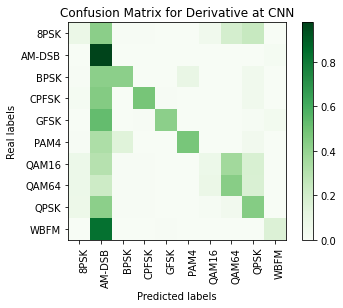

In [ ]:
plot_the_graph(y_pred_cnn, y_test, snr_test,'Derivative', 'CNN')
get_confusion_matrix(y_pred_cnn, y_test, classes_string, 'Derivative', 'CNN')

# Evaluate Integeral

In [ ]:
data_for_integral = data.copy()
int_data = []
for d in data_for_integral:
  d[0] = np.cumsum(d[0])
  d[1] = np.cumsum(d[1])
  int_data.append(d)
int_data = np.array(int_data)
X_train, X_test, y_train, y_test = model_selection.train_test_split(int_data, labels, test_size= 0.3, random_state = 42)

snr_test = y_test[:,1].astype(int)
lb = LabelBinarize()
lb.fit_transform(labels[:,0])
y_test = lb.transform(y_test[:,0])
ev_fcl_model = keras.models.load_model('drive/My Drive/AssignFour/integral_fully_connected.h5')
ev_cnn_model = keras.models.load_model('drive/My Drive/AssignFour/integral_cnn.h5')
y_pred_fcl = ev_fcl_model.predict(X_test)
y_pred_cnn = ev_cnn_model.predict(X_test)

del(int_data)
del(data_for_integral)
gc.collect()

30519

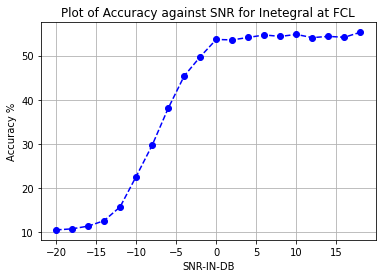

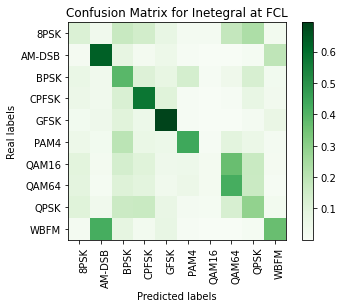

In [ ]:
classes_string = ['8PSK','AM-DSB','BPSK','CPFSK','GFSK','PAM4','QAM16','QAM64','QPSK','WBFM']
plot_the_graph(y_pred_fcl, y_test, snr_test,'Inetegral', 'FCL')
get_confusion_matrix(y_pred_fcl, y_test, classes_string, 'Inetegral', 'FCL')

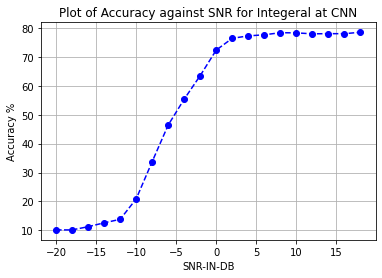

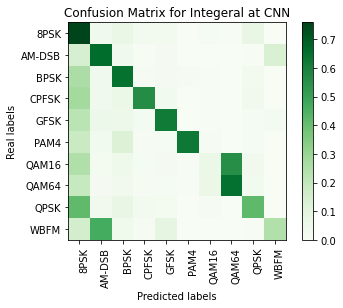

In [ ]:
plot_the_graph(y_pred_cnn, y_test, snr_test,'Integeral', 'CNN')
get_confusion_matrix(y_pred_cnn, y_test, classes_string, 'Integeral', 'CNN')

# Evaluate on the combination

In [ ]:
data_for_comb = data.copy()
comb_data = []
for d in data_for_comb:
  d1 = np.cumsum(d[0])
  d2 = np.cumsum(d[1])
  d1.reshape(1,-1)
  d2.reshape(1,-1)
  d4 = np.gradient(d[0])
  d5 = np.gradient(d[1])
  d4.reshape(1,-1)
  d5.reshape(1,-1)
  d3 = np.array([d[0], d[1], d1 , d2, d4, d5])
  comb_data.append(d3)

comb_data = np.array(comb_data)
X_train, X_test, y_train, y_test = model_selection.train_test_split(comb_data, labels, test_size= 0.3, random_state = 42)

snr_test = y_test[:,1].astype(int)
lb = LabelBinarize()
lb.fit_transform(labels[:,0])
y_test = lb.transform(y_test[:,0])
ev_fcl_model = keras.models.load_model('drive/My Drive/AssignFour/comb_fully_connected.h5')
ev_cnn_model = keras.models.load_model('drive/My Drive/AssignFour/comb_cnn.h5')
y_pred_fcl = ev_fcl_model.predict(X_test)
y_pred_cnn = ev_cnn_model.predict(X_test)

del(comb_data)
del(data_for_comb)
gc.collect()

18669

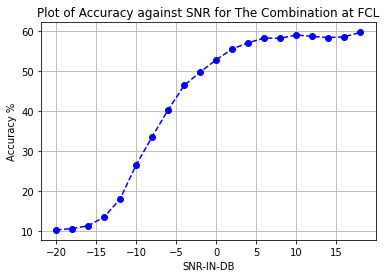

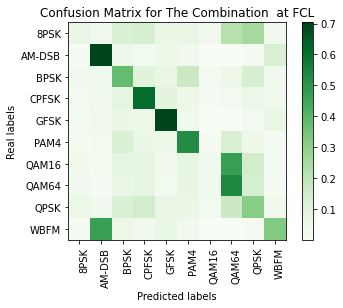

In [ ]:
classes_string = ['8PSK','AM-DSB','BPSK','CPFSK','GFSK','PAM4','QAM16','QAM64','QPSK','WBFM']
plot_the_graph(y_pred_fcl, y_test, snr_test,'The Combination', 'FCL')
get_confusion_matrix(y_pred_fcl, y_test, classes_string, 'The Combination ', 'FCL')

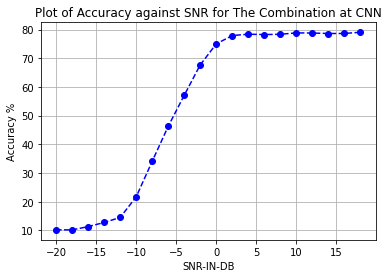

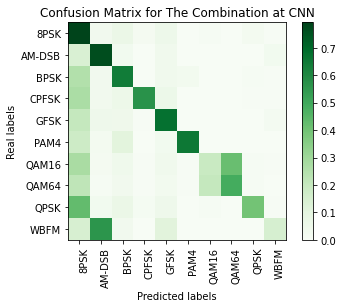

In [ ]:
plot_the_graph(y_pred_cnn, y_test, snr_test,'The Combination', 'CNN')
get_confusion_matrix(y_pred_cnn, y_test, classes_string, 'The Combination', 'CNN')